In [18]:
import torch
from torch import nn
import torchvision.datasets as datasets 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## Loading the dataset and viewing samples

In [19]:
training_data = datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())
testing_data = datasets.MNIST(root='data', download=True, train=False, transform=ToTensor())

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing_data, batch_size=64, shuffle=True)

Displaying a few sample images

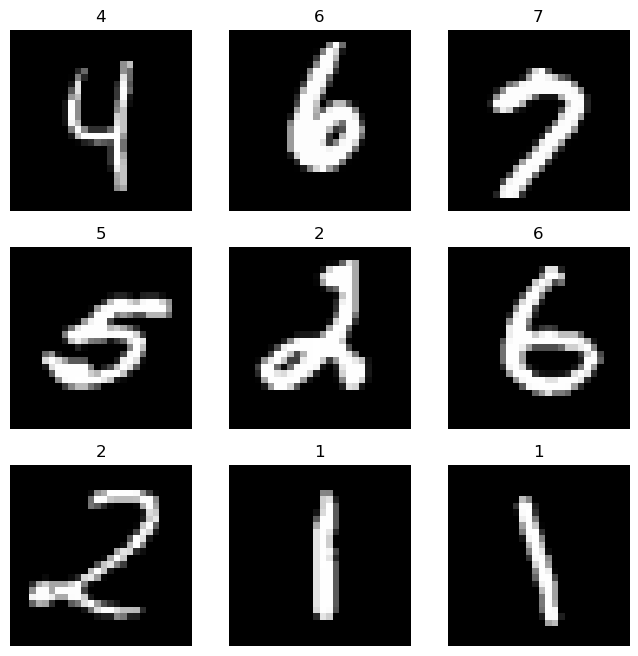

In [20]:
figure = plt.figure(figsize = (8,8))
rows, cols = 3, 3

for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

## Classes and functions

In [21]:
device = (    
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
  )

## Making predictions before training

Getting a random sample

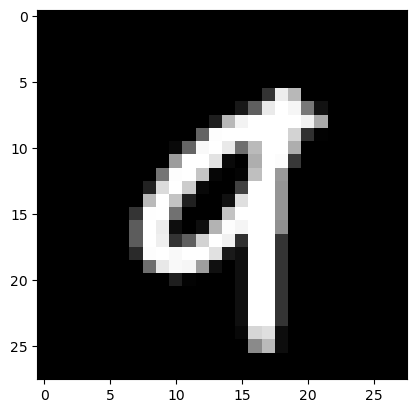

In [25]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.imshow(img.squeeze(), cmap="gray")

Linear model prediction

In [26]:
model = LinearModel().to(device)

output = model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([1])
Actual:  9


In [27]:
output = non_linear_model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([8])
Actual:  9


In [28]:
linear_accuracy = 0
non_linear_accuracy = 0

for i in range(0, 50):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  output = model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    linear_accuracy += 1

  output = non_linear_model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    non_linear_accuracy += 1

print("Linear Accuracy: ", linear_accuracy)
print("Non Linear Accuracy: ", non_linear_accuracy)

Linear Accuracy:  7
Non Linear Accuracy:  5


## Training loop (linear model)

In [29]:
# Linear model
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer()

epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  trainer.train(training_loader, model, loss_fn, optimizer)
  trainer.test(testing_loader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 2.300150  [    0/60000]
loss: 2.293045  [ 6400/60000]
loss: 2.258236  [12800/60000]
loss: 2.220039  [19200/60000]


KeyboardInterrupt: 

## Training loop (with convolutional layers)

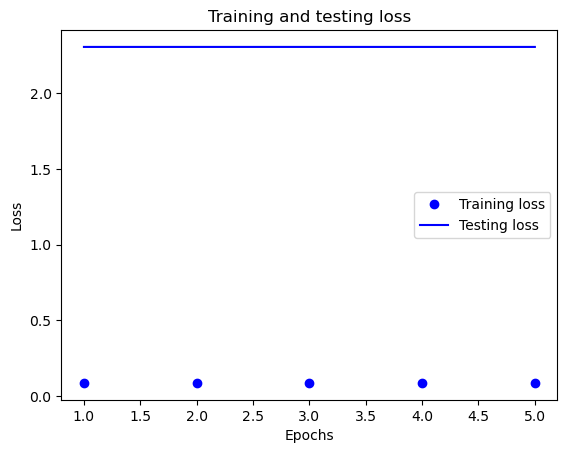

In [ ]:
trainer.plot_training_losses()